In [1]:
# PyTorch is a common library for neural networks in Python. torch.nn is a module for building layers of Neural Networks.
import torch
from torch import nn
import torch.nn.functional as F

# TorchVision is part of the PyTorch environment. It is necessary to download the datasets MNIST (and EMNIST Letters)
import torchvision
import torchvision.transforms as transforms

# Usual mathematical stuff
import numpy as np
import math
# Plots
import matplotlib.pyplot as plt

# Timing
import time
from datetime import datetime
import time

# additional packages
import torchvision.utils as vutils
# from torchviz import make_dot

/usr/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Check if GPU is available

def chooseDevice():
    device = ""
    if torch.cuda.is_available():
        device = torch.device("cuda")
        print("GPU available via cuda")
    else:
        device = torch.device("cpu")
        print("GPU not available, CPU available")
    return device

In [3]:
device = chooseDevice()

GPU not available, CPU available


In [4]:
_ = torch.manual_seed(2472) 

In [5]:
# Extracts the train and test sets from a chosen image dataset
# Values of pixels are normalized between -1 and 1
def getData(dataset = "MNIST", info = True):
    if dataset == "MNIST":
        transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
        train_set = torchvision.datasets.MNIST(root=".", train=True, download=True, transform=transform)
        test_set = torchvision.datasets.MNIST(root=".", train=False, download=True, transform=transform)
    elif dataset == "EMNIST_Letters":
        transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
        train_set = torchvision.datasets.EMNIST(root=".", split="letters", train=True, download=True, transform=transform)
        test_set = torchvision.datasets.EMNIST(root=".", split="letters", train=False, download=True, transform=transform)
    else:
        print("DATASET NOT CORRECTLY DEFINED")
    if info:
        print(train_set)
        print(test_set)
    return train_set, test_set

In [6]:
# Choose which dataset to use

dataset = "MNIST"
#dataset = "EMNIST_Letters"

train_set, test_set = getData(dataset = dataset)

Dataset MNIST
    Number of datapoints: 60000
    Root location: .
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.5,), std=(0.5,))
           )
Dataset MNIST
    Number of datapoints: 10000
    Root location: .
    Split: Test
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.5,), std=(0.5,))
           )


In [7]:
# Get information about the size of the train and test sets.

def dataSize(train_set, test_set):
    n_train_set = train_set.__len__()
    n_test_set = test_set.__len__()
    n_tot = n_train_set + n_test_set
    ratio_train_test = n_train_set / n_test_set
    percentage_train = n_train_set / n_tot
    percentage_test = 1.0 - percentage_train
    return n_train_set, n_test_set, n_tot, ratio_train_test, percentage_train, percentage_test

In [8]:
n_train_set, n_test_set, n_tot, ratio_train_test, percentage_train, percentage_test = dataSize(train_set, test_set)

In [9]:
# Divide dataset into batches

def divideInBatches(train_set, test_set, batch_size, n_train_set, n_test_set):
    # Train set
    n_batches_total = math.ceil(n_train_set/batch_size)
    train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True)
    
    # Test set
    n_batches_total_test = math.ceil(n_test_set/batch_size)
    test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, shuffle=True)
    
    return train_loader, test_loader, n_batches_total, n_batches_total_test

In [10]:
# Corrects EMNIST Letters data

def correctData(real_samples, mnist_labels, dataset):
    if dataset == "EMNIST_Letters":
        real_samples = torch.transpose(real_samples,2,3)
        mnist_labels -= 1
    return real_samples, mnist_labels

In [11]:
# Plot digits or letters

def showImages(samples, true_labels = None, predicted_labels = None, generated = False, predicted = False, epoch = None):
    
    if generated == True and predicted == True:
        plt.close("Generated predicted samples")
        f = plt.figure("Generated predicted samples", figsize = (20,15))
        f.suptitle("Generated predicted samples", fontsize = 30)
    elif generated == True and predicted == False :
        if epoch != None:
            plt.close("Generated samples epoch " + str(epoch))
            f = plt.figure("Generated samples epoch " + str(epoch), figsize = (20,15))
            f.suptitle("Generated samples epoch " + str(epoch), fontsize = 30)
        else:
            plt.close("Generated samples")
            f = plt.figure("Generated samples", figsize = (20,15))
            f.suptitle("Generated samples", fontsize = 30)            
    elif predicted == True and generated == False :
        if epoch != None:
            plt.close("Predicted samples epoch " + str(epoch))
            f = plt.figure("Predicted samples epoch " + str(epoch), figsize = (20,15))
            f.suptitle("Predicted samples epoch " + str(epoch), fontsize = 30)
        else:
            plt.close("Predicted samples")
            f = plt.figure("Predicted samples", figsize = (20,15))
            f.suptitle("Predicted samples", fontsize = 30)            
    else:
        plt.close("MNIST samples")
        f = plt.figure("MNIST samples", figsize = (20,15))
        f.suptitle("MNIST training samples", fontsize = 30)
    f.subplots_adjust(wspace=0.2, hspace=0.4)
    plt.rc('axes', titlesize=20)
    
    for i in range(16):
        if i < samples.size(0):
            if generated:
                a = samples[i][0].detach().numpy()
            else:
                a = samples[i]
            fi = f.add_subplot(4, 4, i + 1)
            fi.imshow(a.reshape(28, 28), cmap="gray_r")
            plt.xticks([])
            plt.yticks([]) 
            if generated == True and predicted == True :
                fi.title.set_text("Pred: " + str(predicted_labels[i].detach().numpy()))
            elif generated == True and predicted == False :
                fi.title.set_text("Sample " + str(i))
            elif predicted == True and generated == False :
                fi.title.set_text("Pred: " + str(predicted_labels[i].detach().numpy()) +  ", true: " + str(true_labels[i].detach().numpy()))
            else:
                fi.title.set_text("Sample " + str(i) + ": " + str(true_labels[i].detach().numpy()))
    
    now = datetime.now().strftime("%Y_%m_%d__%H_%M_%S")
    if generated == True and predicted == True :
        f.savefig('./Figures/Sample_generated__' + now + '__epoch_' + str(epoch) + '.svg')
    elif generated == True and predicted == False :
        f.savefig('./Figures/Sample_generated_predicted__' + now + '__epoch_' + str(epoch) + '.svg')
    elif predicted == True and generated == False :
        f.savefig('./Figures/Sample_predicted__' + now + '__epoch_' + str(epoch) + '.svg')
    else:
        f.savefig('./Figures/Sample_MNIST.svg')

In [12]:
# showImages(real_samples, true_labels = mnist_labels)

In [13]:

def computeGANAccuracy(y_predicted,y_true):
    
    accuracy = torch.sum((y_predicted>0) == y_true) / len(y_true)

    return accuracy

In [14]:
def generate_latent_vectors(dim_latent_space, batch_size):
    # generate latent vectors based on a standard normal distribution
    latent_vectors = torch.randn(dim_latent_space * batch_size).reshape(batch_size, dim_latent_space)

    return latent_vectors

In [15]:
def loadModel(model, model_name, date_time):
    model.load_state_dict(torch.load('./Models/' + model_name ))
    model.eval()
    return model

In [16]:
def numberClasses(dataset):
    n_classes = len(dataset.classes)
    return n_classes

In [17]:
def plot_cnn_prediction(classifier, data_loader, min=0, max=5):
    for i, data in enumerate(data_loader, 0):
        if i in range(min, max):
            X = data[0].to(device)
            y_true = data[1].to(device)
            result = classifier(X)
            y_hat = classifier.predictLabels(result)[0]
            print("Saving Images: %d" % (i+1))
            showImages(X, true_labels=y_true, predicted_labels=y_hat, predicted=True)

In [18]:
class Generator(nn.Module):

    def __init__(self, dim_latent_space):
        super().__init__()
        self.dim_latent_space = dim_latent_space
        self.fc = nn.Linear(self.dim_latent_space, 64*7*7)
        self.trans_conv1 = nn.ConvTranspose2d(64, 64, kernel_size = 3, stride = 2, padding = 1, output_padding = 1)
        self.batch_norm1 = nn.BatchNorm2d(64)
        self.trans_conv2 = nn.ConvTranspose2d(64, 32, kernel_size = 3, stride = 1, padding = 1)
        self.batch_norm2 = nn.BatchNorm2d(32)
        self.trans_conv3 = nn.ConvTranspose2d(32, 16, kernel_size = 3, stride = 1, padding = 1)
        self.batch_norm3 = nn.BatchNorm2d(16)
        self.trans_conv4 = nn.ConvTranspose2d(16, 1, kernel_size = 3, stride = 2, padding = 1, output_padding = 1)
        
    def forward(self, x):                   # Input = batch_size*dim_latent_space
        x = self.fc(x)                      # Output = batch_size*(64*7*7)
        x = x.view(-1, 64, 7, 7)            # Output = batch_size*64*7*7
        x = self.trans_conv1(x)             # Output = batch_size*64*14*14
        x = F.relu(self.batch_norm1(x))
        x = self.trans_conv2(x)             # Output = batch_size*32*14*14
        x = F.relu(self.batch_norm2(x))
        x = self.trans_conv3(x)             # Output = batch_size*16*14*14
        x = F.relu(self.batch_norm3(x))     
        x = self.trans_conv4(x)             # Output = batch_size*1*28*28
        x = torch.tanh(x)
        return x

class Discriminator(nn.Module):
    
    def __init__(self):
        super().__init__()
        self.conv0 = nn.Conv2d(1, 32, kernel_size = 3, stride = 2, padding = 1)     
        self.conv0_drop = nn.Dropout2d(0.25)
        self.conv1 = nn.Conv2d(32, 64, kernel_size = 3, stride = 1, padding = 1)
        self.conv1_drop = nn.Dropout2d(0.25)
        self.conv2 = nn.Conv2d(64, 128, kernel_size = 3, stride = 1, padding = 1)
        self.conv2_drop = nn.Dropout2d(0.25)
        self.conv3 = nn.Conv2d(128, 128, kernel_size = 3, stride = 2, padding = 1)
        self.conv3_drop = nn.Dropout2d(0.25)
        self.fc = nn.Linear(128*7*7, 1)
    
    def forward(self, x):                               # Input = batch_size*1*28*28
        x = x.view(-1, 1, 28, 28)                       # Output = batch_size*1*28*28
        x = F.leaky_relu(self.conv0(x), 0.2)            # Output = batch_size*32*14*14
        x = self.conv0_drop(x)
        x = F.leaky_relu(self.conv1(x), 0.2)            # Output = batch_size*64*14*14
        x = self.conv1_drop(x)
        x = F.leaky_relu(self.conv2(x), 0.2)            # Output = batch_size*128*14*14
        x = self.conv2_drop(x)
        x = F.leaky_relu(self.conv3(x), 0.2)            # Output = batch_size*128*7*7
        x = self.conv3_drop(x)
        x = x.view(-1, 128*7*7)                         # Output = batch_size*(128*7*7)
        x = self.fc(x)                                  # Output = batch_size*1
        return x
class CNN(nn.Module):
    def __init__(self, n_classes):
        super(CNN, self).__init__()
        self.n_classes = n_classes
        self.conv1 = nn.Sequential(             # Images input is batch_size*1*28*28
            nn.Conv2d(1, 16, 5, 1, 2),          # Output is batch_size*16*28*28
            nn.ReLU(),                      
            nn.MaxPool2d(kernel_size=2),        # Output is batch_size*16*14*14
        )
        self.conv2 = nn.Sequential(         
            nn.Conv2d(16, 32, 5, 1, 2),         # Output is batch_size*32*14*14
            nn.ReLU(),                      
            nn.MaxPool2d(2),                    # Output is batch_size*32*7*7
        )
        # fully connected layer, output one number for each class
        self.out = nn.Sequential(         
            nn.Linear(32 * 7 * 7, self.n_classes),          # Output is batch_size*n_classes
        )
    
    def scaleToProbabilities(self, outmap, scale_factor = 3): 
        # scale_factor allows to scale your output before passing it into the softmax function 
        # in order to get numbers interpratble as probabilities
        
        flattened_outmap = outmap.view(outmap.shape[0], -1)
        outmap_std = torch.std(flattened_outmap, dim = 1).view(-1, 1)
        outmap_scaled_std = torch.div(outmap, outmap_std)
        probabilities = nn.functional.softmax(outmap_scaled_std*scale_factor, dim=1)
        return probabilities
    
    def predictLabels(self, outmap, scale_factor = 3):
        probabilities = self.scaleToProbabilities(outmap, scale_factor = 3)
        certainty, predicted_labels = torch.max(probabilities, 1)
        predicted_labels = predicted_labels.data.squeeze()
        certainty = certainty.data.squeeze()
        return predicted_labels, probabilities, certainty
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = x.view(x.size(0), 32 * 7 * 7)
        output = self.out(x)
        return output

## 3 Explore the latent space

In [19]:
#now we pass rlvs_lot through the image generator
#print(rlvs_lot)--> i just wanted to check it, ignore it
# Paramater for the batch size
# Predefined value = 32

n_classes = numberClasses(train_set)



dim_latent_space = 100
batch_size = 32
nb_batches = 200



date_time = ""
genname = "gen5"
disname = "dis5"
cnnname = "cnn_5_epochs"

generator = Generator(dim_latent_space)
discriminator = Discriminator()
cnn = CNN(n_classes)

#loading the generator, discriminator and cnn model (classifier)
generator =  loadModel(generator, genname, date_time)
discriminator = loadModel(discriminator, disname, date_time)
cnn = loadModel(cnn, cnnname, date_time)



generator.eval()
discriminator.eval()
cnn.eval()


CNN(
  (conv1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (out): Sequential(
    (0): Linear(in_features=1568, out_features=10, bias=True)
  )
)

### 3.1 Combine your generator and your classifier

- First step: Generation of a lot of triplets (latent vector, generated image, predicted label). To do so, you randomly generate latent vectors, which you pass in your generator to create the corresponding images, and then give the latter to you classifer to get its predicted labels.

- Second step: select the images with the highest quality, i.e. the ones looking visually the most like true data.
An idea to find them is to keep only the labels predicted with high probability, as they should be the most
unambiguous ones. For example, you could set a minimum threshold on the prediction ”certainty” (defined in part
1 as the ”probability”/output of the most activated label in your classifier last layer). We will call these ”labelled
latent vectors”. 

In [20]:
def generate_triplets(dim_latent_space=dim_latent_space ,batch_size=batch_size ,nb_batches=nb_batches, generate_latent_vectors=generate_latent_vectors, generator=generator, cnn=cnn):
    list_lat_vec = []
    list_images = []
    list_cnn = []


    for i in range(nb_batches):
      # make batch_size*nb_batches triplets with the output of cnn
      list_lat_vec.append(generate_latent_vectors(dim_latent_space, batch_size))
      list_images.append(generator(list_lat_vec[i]))
      list_cnn.append(cnn(list_images[i]))
        
    return list_lat_vec, list_images, list_cnn

def keep_above_threshold(list_lat_vec, list_images, list_cnn, thresh, generator=generator, cnn=cnn, n_classes=n_classes):
    flist_lat_vec = []
    flist_images = []
    flist_cnn = []
    
    nb_batches = len(list_lat_vec)
    batch_size = len(list_lat_vec[0])
    
    
    nbnb0 = np.zeros(n_classes)
    nbnb = np.zeros(n_classes)

    for i in range(nb_batches):
      #  if certainty bigger that the threshold, save the triplet with the label

      prob = cnn.predictLabels(list_cnn[i])
      # print((prob))
      for j in range(batch_size):

        # with no threshold
        nbnb0[prob[0][j].item()] += 1


        # with threshold=thresh
        if prob[2][j].item()> thresh:
          flist_lat_vec.append(list_lat_vec[i][j])
          flist_images.append(list_images[i][j])
          flist_cnn.append(prob[0][j].item())
          nbnb[flist_cnn[-1]] +=1
            
    return flist_lat_vec, flist_images, flist_cnn, nbnb, nbnb0

    


### 3.2 Distribution of classes

Generate a lot of labelled latent vectors and count the proportion of each class. 
- Are all labels represented? 
- Are they represented equally? 
- How does the certainty threshold influence that repartition? 

- Don’t forget to report your experiment parameters (dataset, latent vector generating distribution, number of samples, certainty threshold).

/tmp/ipykernel_1272281/2532391499.py:21: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  f.show()


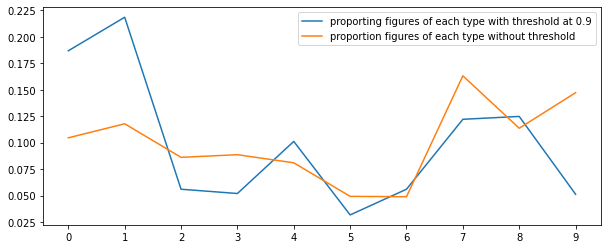

In [21]:
# dim_latent_space = 100
# nb_batches = 200
# batch_size = 32
# thresh = 0.9


thresh = 0.9

list_lat_vec, list_images, list_cnn = generate_triplets()
flist_lat_vec, flist_images, flist_cnn, nbnb, nbnb0= keep_above_threshold(list_lat_vec, list_images, list_cnn, thresh)


# number of  
f = plt.figure()
f.set_figwidth(10)
ax1 = plt.subplot()
ax1.set_xticks(np.arange(n_classes))
ax1.plot(nbnb/sum(nbnb), label="proporting figures of each type with threshold at "+str(thresh))
ax1.plot(nbnb0/sum(nbnb0), label="proportion figures of each type without threshold")
ax1.legend()
f.show()

### 3.3 Mean of your latent vectors
Take the mean of your labelled latent vectors from each class, we call these new vectors ”mean latent vectors”.
- Show the corresponding images. 
- Are these results better than the ones from before? 

NB : "your labelled latent vectors" = latent vectors with threshold 

In [22]:
def devide_in_label(flist_lat_vec, flist_cnn, n_classes=n_classes, cnn=cnn):
    #adding each labelled latent vector to its corresponding class

    vector_list_label = [[] for i in range(n_classes)]

    nb_vecs = len(flist_lat_vec)
    
    for i in range(nb_vecs):
        lab = flist_cnn[i]
        vector_list_label[lab].append(flist_lat_vec[i]) 
    return vector_list_label
    
def compute_mean_label(vector_list_label):
    n_classes = len(vector_list_label)
    mean_label = [[] for i in range (n_classes)]
    
    for i in range(n_classes):
        mean = torch.mean(torch.stack(vector_list_label[i]), 0) #calculating the mean of these mean latent vectors
        mean_label[i] = mean
    return mean_label


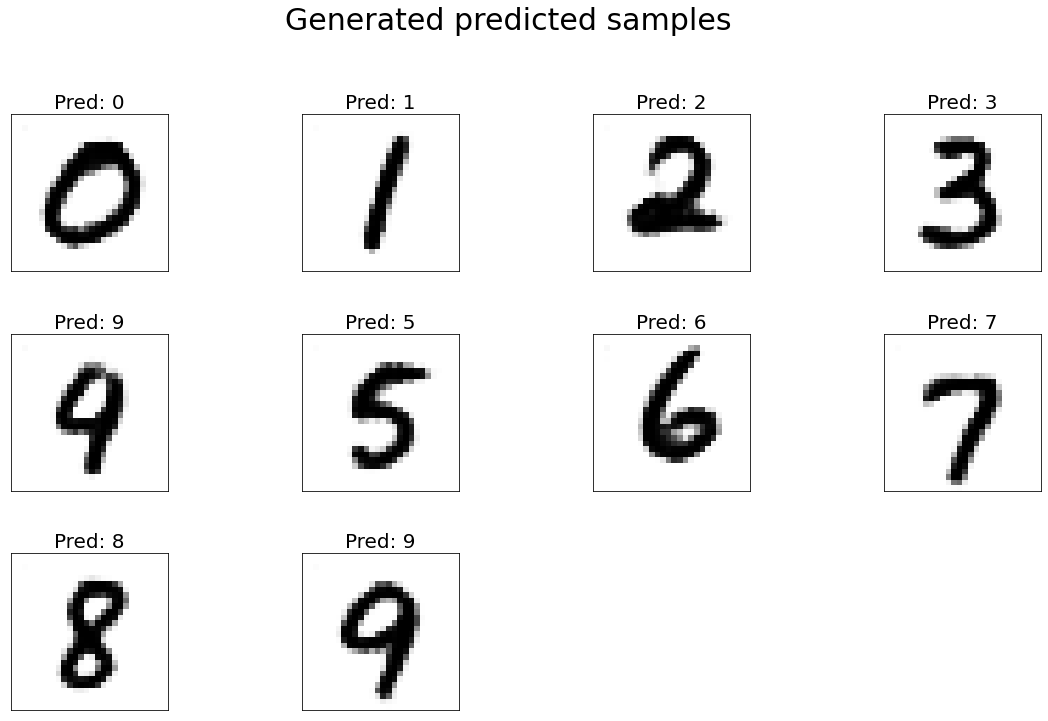

In [23]:
# mean labeled label vectors

# list_lat_vec = []
# list_lab = []
nb_batches = 200
thresh = 0.9
list_lat_vec, list_images, list_cnn = generate_triplets(nb_batches = nb_batches)
flist_lat_vec, flist_images, flist_cnn, nbnb, nbnb0= keep_above_threshold(list_lat_vec, list_images, list_cnn, thresh)
vector_list_label = devide_in_label(flist_lat_vec, flist_cnn)
mean_label = compute_mean_label(vector_list_label)



    
    


# labeled label vectors

# to do: 




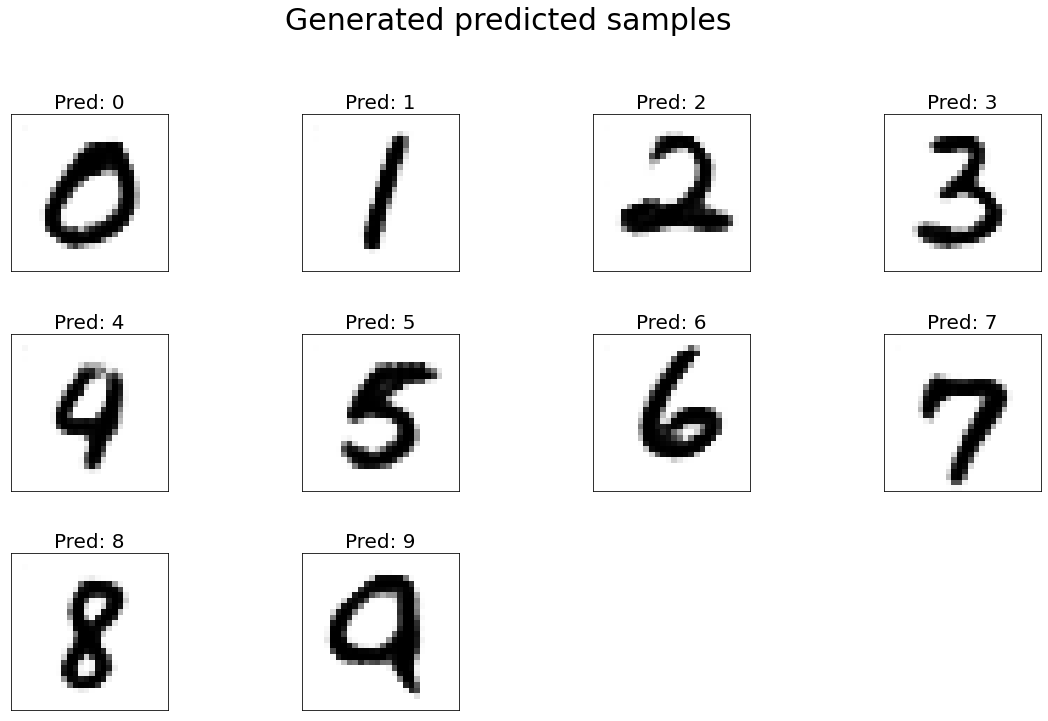

In [38]:
list_images = []
a = generator(torch.stack(mean_label))
showImages(a, generated = 1, predicted_labels = cnn.predictLabels(cnn(a))[0], predicted = 1, epoch = 5)
plt.show()


### 3.4 Norms and distances
- Compute the norms of randomly generated latent vectors such as the labelled latent vectors. 
- Compute the norms of the mean latent vectors. 
  - How to explain the observed gap?

In [24]:
def compute_norms(n_classes, vector_list_label):
    norms = np.zeros(n_classes)
    normm = np.zeros(n_classes)
    norm = 0

    counter = 0
    for i in range(n_classes):
        counterc = 0

        for j in range(len(vector_list_label[i])):
            norm += torch.norm(vector_list_label[i][j])
            norms[i] += torch.norm(vector_list_label[i][j])
            counterc +=1
            counter +=1

        norms[i]/= counterc    
        normm[i] = torch.norm(mean_label[i])
    norm/= counter
    return norms, normm, norm.item()
    
def compute_distances(n_classes, vector_list_label, mean_label):
    mean_distance = np.zeros((n_classes, n_classes))


    for i in range(n_classes):
        counterc = 0
        for j in range(len(vector_list_label[i])):
            for k in range(n_classes):  
                mean_distance[i][k]  +=  np.linalg.norm(vector_list_label[i][j].numpy()-mean_label[k].numpy())
            counterc +=1
        mean_distance[i]/=counterc
    return mean_distance

    

In [25]:
norms, normm, norm = compute_norms(n_classes, vector_list_label)


print(norms)
print(normm)
print(norm)

[ 9.96551801 10.05562988 10.11908779  9.93880492  9.9399231   9.91503228
  9.98164266  9.98662819  9.91368552  9.77698405]
[1.88184214 1.83352935 2.27897906 2.18990898 1.85473537 2.3667779
 2.16098619 1.94776297 1.74942553 1.90774786]
9.976651191711426


- Compute the distances between labelled latent vectors and the mean latent vectors of each class. 
  - What do you observe? 

In [26]:
import seaborn as sns
nb_batches = 500

list_lat_vec, list_images, list_cnn = generate_triplets(nb_batches = nb_batches)

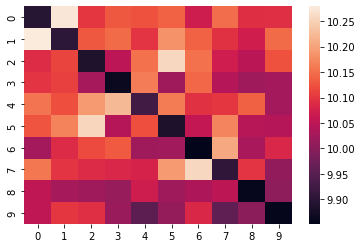

<AxesSubplot:>

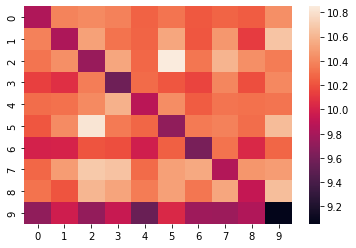

In [27]:
# heatmat seems more pronounced with higher thresholds

thresh = 0
flist_lat_vec, flist_images, flist_cnn, nbnb, nbnb0= keep_above_threshold(list_lat_vec, list_images, list_cnn, thresh)
vector_list_label = devide_in_label(flist_lat_vec, flist_cnn)
mean_label = compute_mean_label(vector_list_label)
mean_distance = compute_distances(n_classes, vector_list_label, mean_label)
sns.heatmap(mean_distance)
plt.show()

thresh = 0.97
flist_lat_vec, flist_images, flist_cnn, nbnb, nbnb0= keep_above_threshold(list_lat_vec, list_images, list_cnn, thresh)
vector_list_label = devide_in_label(flist_lat_vec, flist_cnn)
mean_label = compute_mean_label(vector_list_label)
mean_distance = compute_distances(n_classes, vector_list_label, mean_label)
sns.heatmap(mean_distance)


This brings you to consider classifying to the nearest mean vector, which is known as Minimum
Distance to Mean (MDM) classification. 
- Compare MDM (criterion = minimum distance mean vectors) and CNN classification (criterion = maximum activation of the last layer). 
  - Do both classifiers agree? 
  - Try with different values of the certainty threshold

In [28]:
def MDM_classify(mean_label, vector_list_label):
    n_classes = len(mean_label)
    MDM_label = np.zeros((n_classes, n_classes))
    
    for i in range(n_classes):
        for j in range(len(vector_list_label[i])):
            distance = np.zeros(n_classes)
            for k in range(n_classes):
                distance[k]  =  np.linalg.norm(vector_list_label[i][j].numpy()-mean_label[k].numpy())
            index_min = np.argmin(distance)
            MDM_label[i][index_min] += 1
        MDM_label[i] /= len(vector_list_label[i])
    return MDM_label
                

        



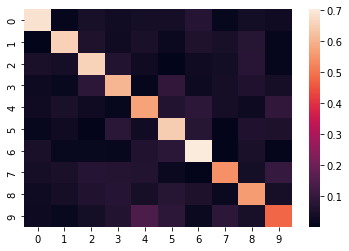

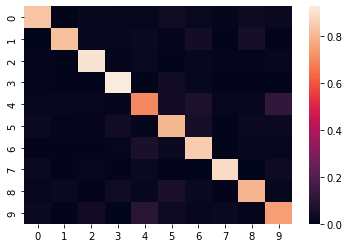

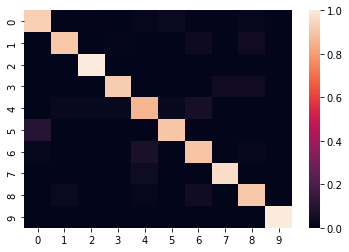

In [29]:

for thresh in [0, 0.9, 0.98]:
    flist_lat_vec, flist_images, flist_cnn, nbnb, nbnb0= keep_above_threshold(list_lat_vec, list_images, list_cnn, thresh)
    vector_list_label = devide_in_label(flist_lat_vec, flist_cnn)
    mean_label = compute_mean_label(vector_list_label)
    MDM_label = MDM_classify(mean_label, vector_list_label)    
    sns.heatmap(MDM_label)
    plt.show()

###  3.5 Interpolation for exploration
The goal is to examine how digits (or letters) transform one into the other according to your model. First,
within the same class, then from one class to another.
 - First, choose two triplets within the same class that you find visually satisfying.  We call those latent vectors extreme latent vectors”. 
 

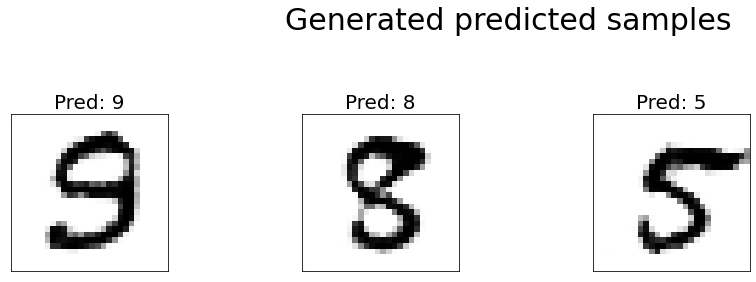

In [30]:
i = 9
# 11, 12, 14
# vec = torch.stack([list_lat_vec[i][11],list_lat_vec[i][13],list_lat_vec[i][10]])
vec = torch.load('tensor35.pt')
image = generator(vec)
label = cnn.predictLabels(cnn(image))[0]
showImages(image, generated = 1, predicted_labels = label, predicted = 1, epoch = 5)
# torch.save(vec, "tensor35.pt")

 - Then, create intermediate triplets by interpolating linearly between the extreme latent vectors. 
 - Show how one image evolves into the other one by linear interpolation in the latent space. 
 - Compare the interpolants to the extremes, for 3 distinct examples.


In [31]:
def get_interpolation(vec1, vec2, nb_images=16):
    intermediaries = np.around(np.linspace(0, 1, nb_images), 2)
    interpolation = torch.stack([torch.lerp(vec[0], vec[1], i) for i in intermediaries])
    images = generator(interpolation)
    labels = cnn.predictLabels(cnn(images))[0]
    return intermediaries, interpolation, images, labels

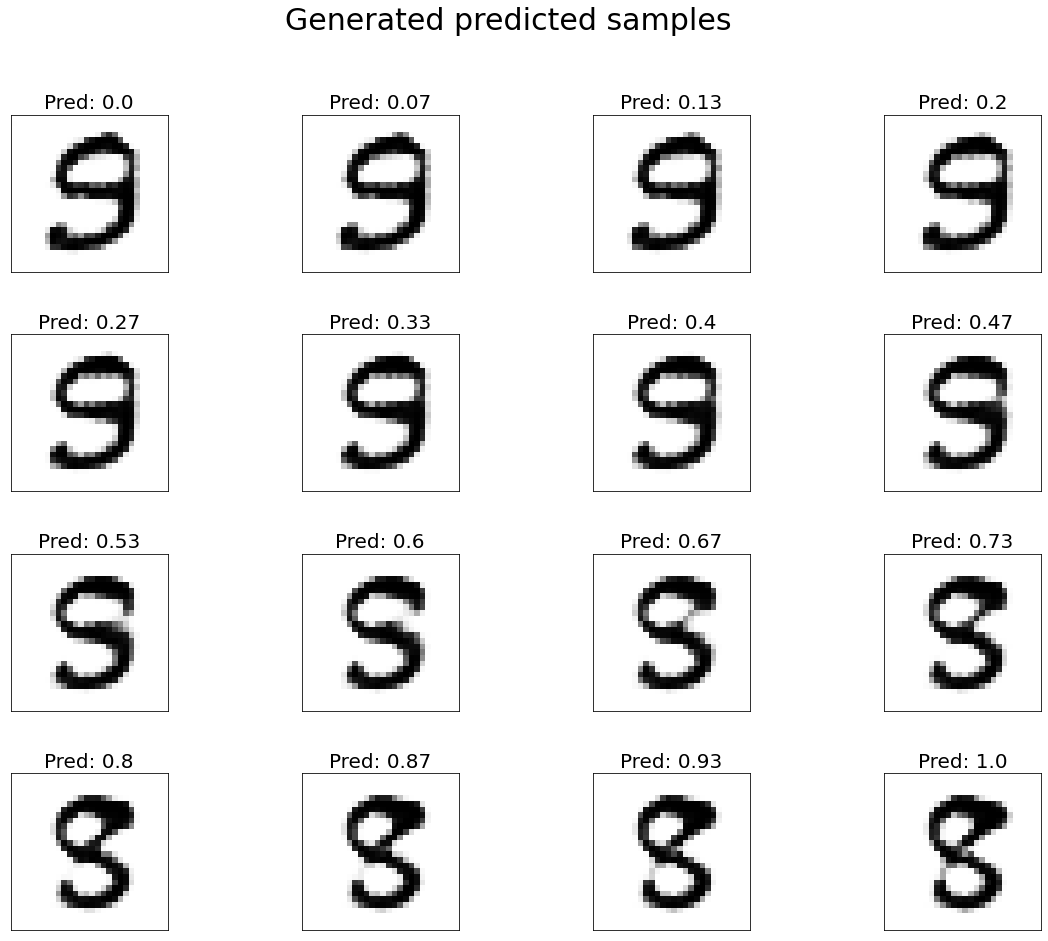

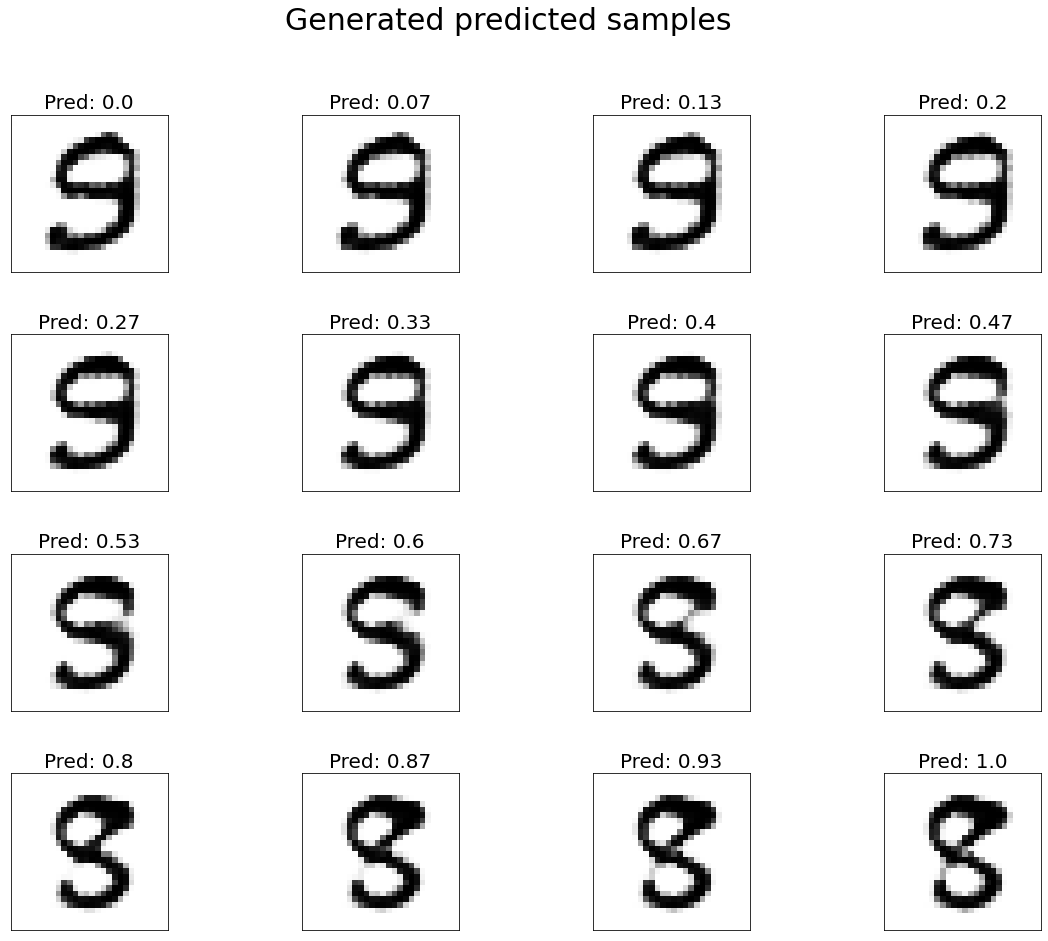

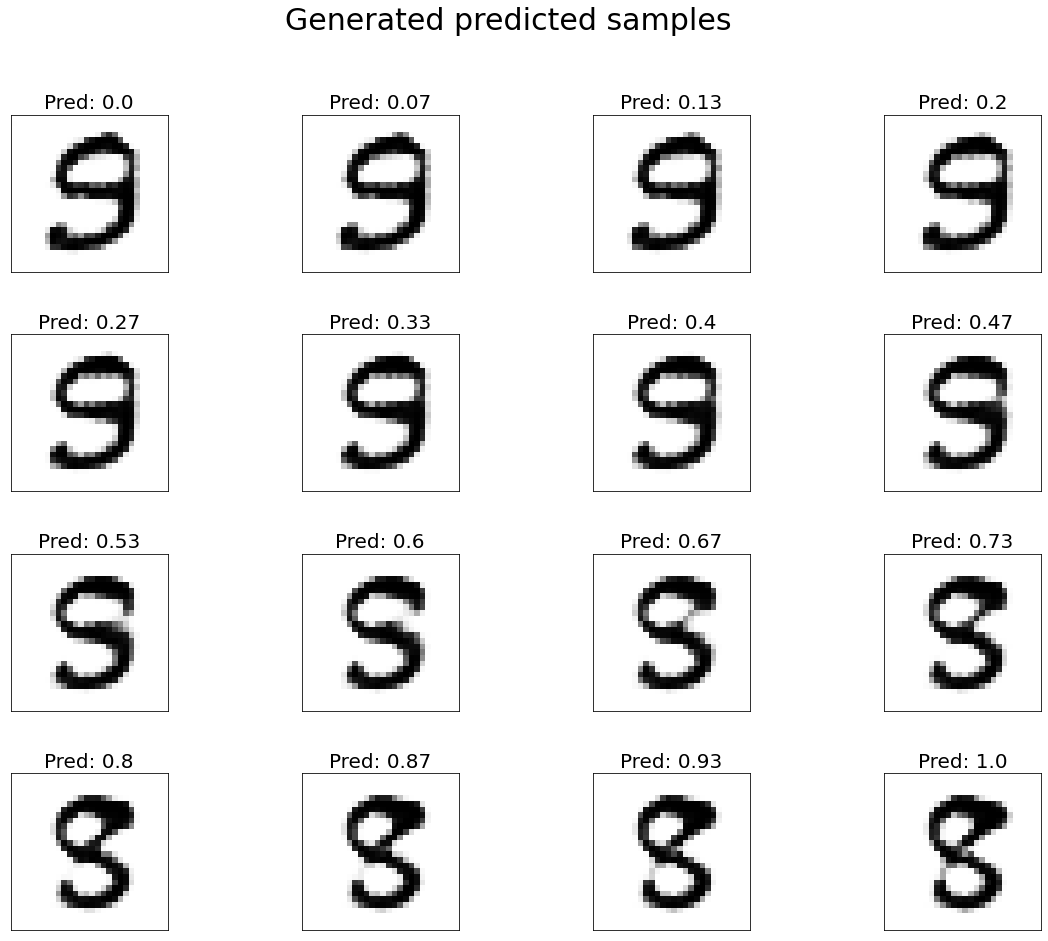

In [32]:

nb_images=16

vec1 = vec[0]
vec2 = vec[1]
vec3 = vec[2]

intermediaries, interpolation, images, labels = get_interpolation(vec1, vec2, nb_images=16)
showImages(images, generated = 1, predicted_labels = torch.tensor(intermediaries), predicted = 1, epoch = 5)
plt.show()

intermediaries, interpolation, images, labels = get_interpolation(vec1, vec3, nb_images=16)
showImages(images, generated = 1, predicted_labels = torch.tensor(intermediaries), predicted = 1, epoch = 5)
plt.show()


intermediaries, interpolation, images, labels = get_interpolation(vec3, vec2, nb_images=16)
showImages(images, generated = 1, predicted_labels = torch.tensor(intermediaries), predicted = 1, epoch = 5)
plt.show()



 -  Now, choose two extreme latent vectors from different classes (for example, corresponding to two mean latent vectors). Then, repeat the instructions from above for these new extreme latent vectors.

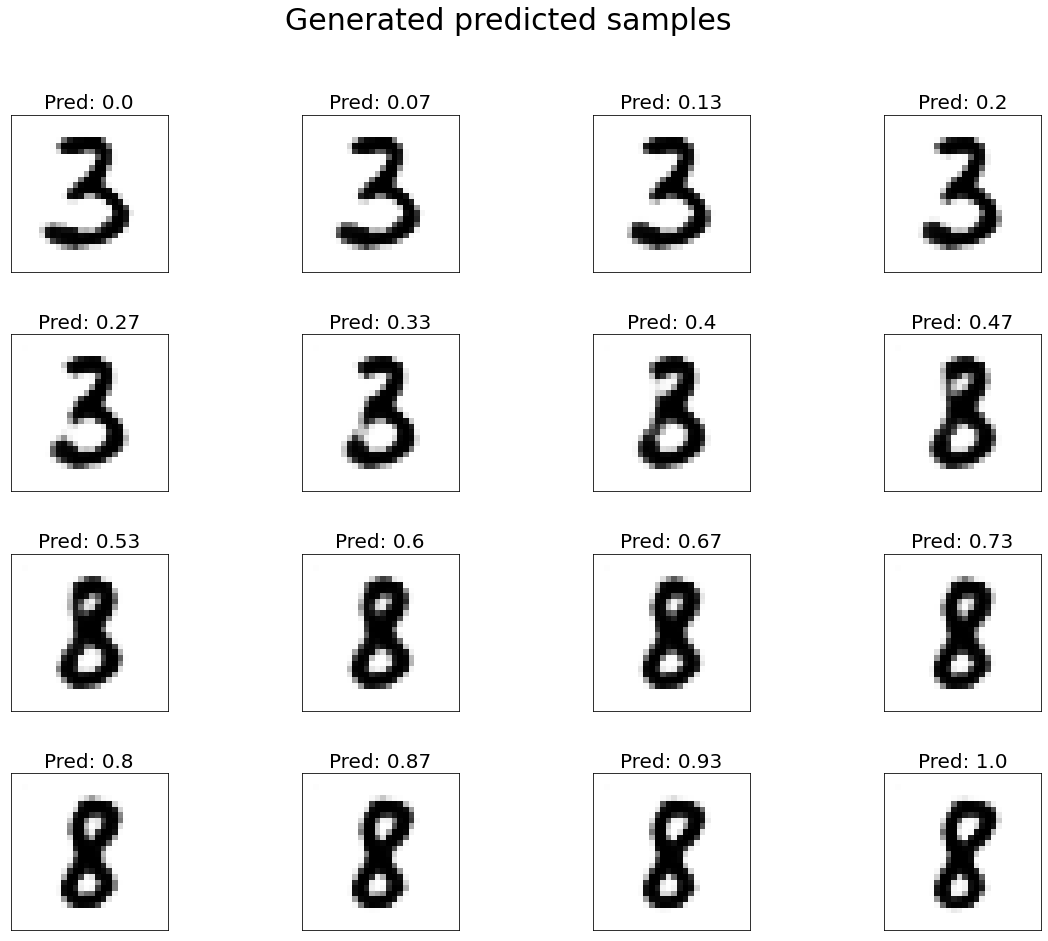

In [33]:
nb1 = 3
nb2 = 8
interpolation1 = torch.stack([torch.lerp(mean_label[nb1], mean_label[nb2], i) for i in intermediaries])
image = generator(interpolation1)
label = cnn.predictLabels(cnn(image))[0]
showImages(image, generated = 1, predicted_labels = torch.tensor(intermediaries), predicted = 1, epoch = 7)
plt.show()

# for 3 to 8: seems an 8 for a very long time, sharp decline thenn seems a 3 for a very long time
# seems reasonable as strategy to fool discriminator with random data but needs more research to be sure

### 3.6 Noise for exploration
Generate ”noise latent vectors” with 0 < σ < 1: either from a normal zero-mean distribution (sampled in
N (0, σIdim lat) ), either from a uniform distribution (sampled from [−σ, σ]dim lat). 

More precisely, try σ ∈ {0.1, 0.3, 0.5, 0.7, 0.9}.



In [34]:
# dim_latent_space = 100
# nb_batches = 200
# batch_size = 32
# thresh = 0.9

def getNormal(sigma, dim_latent_space):
    return torch.normal(torch.zeros(dim_latent_space), torch.ones(dim_latent_space)*sigma)

def getUni(sigma, dim_latent_space):
    return torch.rand(dim_latent_space)*2*sigma-torch.ones(dim_latent_space)*sigma


sigmas = [0.1, 0.3, 0.5, 0.7, 0.9]

nb_pictures = 8
list_uni = []
list_normal = []

for i in range(len(sigmas)):
    list_uni.append([])
    list_normal.append([])
    for j in range(nb_pictures):
        list_uni[i].append(getUni(sigmas[i], dim_latent_space))
        list_normal[i].append(getNormal(sigmas[i], dim_latent_space))

list_uni = torch.stack([torch.stack(i) for i in list_uni])
list_normal = torch.stack([torch.stack(i) for i in list_normal])


You then add those noise vectors to the mean latent vectors to create ”variation latent vectors”. 
Compare your variation latent vectors with the mean latent vector in terms of visual quality. 


In [35]:
# # sigmas = [0.1, 0.3, 0.5, 0.7, 0.9]
# # chose sigma from list hereup
# sigma = 0.9

# index  = sigmas.index(sigma)

# print("uni noise")
# for i in range(n_classes):
#     print("for vector "+str(i))
#     f = torch.stack([ mean_label[i] for j in range(nb_pictures)])
#     noizy_vecors = list_uni[index]+ f
#     a = generator(noizy_vecors)
#     showImages(a, generated = 1, predicted_labels = cnn.predictLabels(cnn(a))[0], predicted = 1, epoch = 5)
#     plt.show()



# print("normal noise")
# for i in range(n_classes):
#     print("for vector "+str(i))
#     f = torch.stack([ mean_label[i] for j in range(nb_pictures)])
#     noizy_vecors = list_normal[index]+ f
#     a = generator(noizy_vecors)
#     showImages(a, generated = 1, predicted_labels = cnn.predictLabels(cnn(a))[0], predicted = 1, epoch = 5)
#     plt.show()



Compare your variation latent vectors with the mean latent vector in terms of labels and 
Then, analyze the impact of the value of σ (how far from the mean latent vectors) on the variation latent vectors.

In [60]:
def LabelOfNoisy(mean_label, noizes):
    n_classes = len(mean_label)
    classified_as = np.zeros((n_classes, n_classes))
    
    for i in range(n_classes):
        for j in range(len(noizes)):
            vec = mean_label[i] + noizes[j]
            index = cnn.predictLabels(cnn(generator(vec)))[0].item()
            
            classified_as[i][index] += 1

        classified_as [i]/= len(noizes)
    return classified_as

Uniform noizes
sigma = 0.1


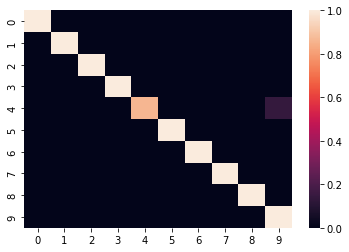

sigma = 0.3


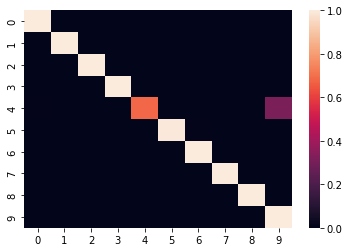

sigma = 0.5


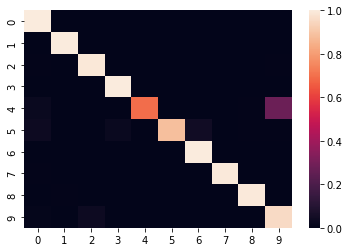

sigma = 0.7


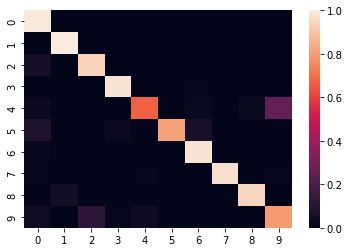

sigma = 0.9


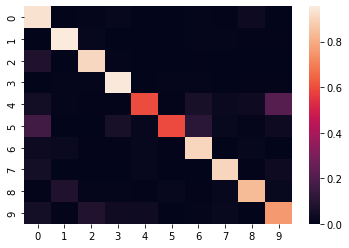

Normal noizes
sigma = 0.1


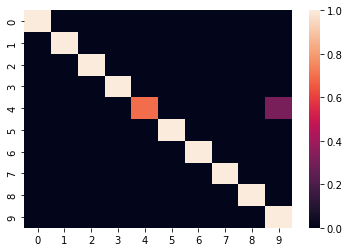

sigma = 0.3


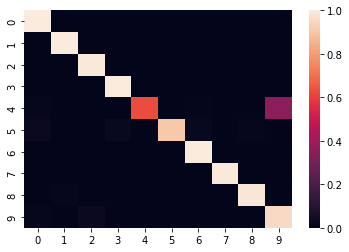

sigma = 0.5


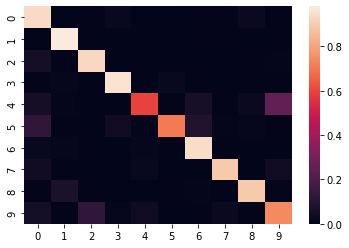

sigma = 0.7


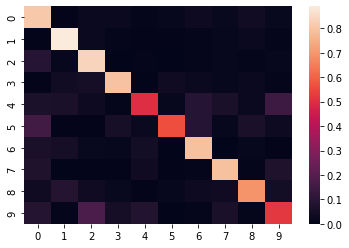

sigma = 0.9


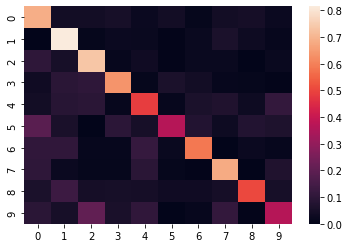

In [63]:


nb_noizes = 200
list_uni = []
list_normal = []

for i in range(len(sigmas)):
    list_uni.append([])
    list_normal.append([])
    for j in range(nb_noizes):
        list_uni[i].append(getUni(sigmas[i], dim_latent_space))
        list_normal[i].append(getNormal(sigmas[i], dim_latent_space))

list_uni = torch.stack([torch.stack(i) for i in list_uni])
list_normal = torch.stack([torch.stack(i) for i in list_normal])



print("Uniform noizes")
for sigma in sigmas:
    print("sigma = "+str(sigma))
    index  = sigmas.index(sigma)
    mat = LabelOfNoisy(mean_label, list_uni[index])
    sns.heatmap(mat)
    plt.show()


print("Normal noizes")
for sigma in sigmas:
    print("sigma = "+str(sigma))
    index  = sigmas.index(sigma)
    mat = LabelOfNoisy(mean_label, list_normal[index])
    sns.heatmap(mat)
    plt.show()   

## 4 Create what you want

### 4.1 Mandatory: Open message

## 5 Our creation : certainty map